# Imports

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from importlib import reload
from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.api import Holt

import acquire
import prepare

# Excercises

The end result of this exercise should be a Jupyter notebook named model.

Use either the SAAS dataset or the store data and:

In [104]:
#import sales
sales = acquire.acquire_all_data()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sale_amount    913000 non-null  float64
 1   item_brand     913000 non-null  object 
 2   item_name      913000 non-null  object 
 3   item_price     913000 non-null  float64
 4   item_upc12     913000 non-null  object 
 5   item_upc14     913000 non-null  object 
 6   store_address  913000 non-null  object 
 7   store_city     913000 non-null  object 
 8   store_state    913000 non-null  object 
 9   store_zipcode  913000 non-null  object 
 10  month          913000 non-null  object 
 11  day of week    913000 non-null  object 
 12  sales_total    913000 non-null  float64
dtypes: float64(3), object(10)
memory usage: 97.5+ MB

        Info: None

        Nulls:
sale_amount      0
item_brand       0
item_name        0
item_price       0
item_upc12       0
item_upc14   

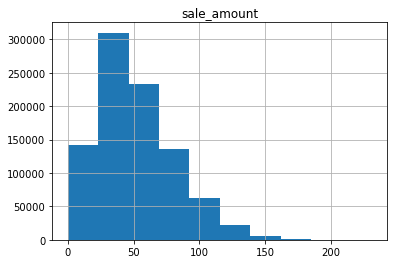

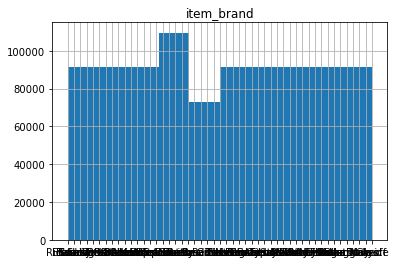

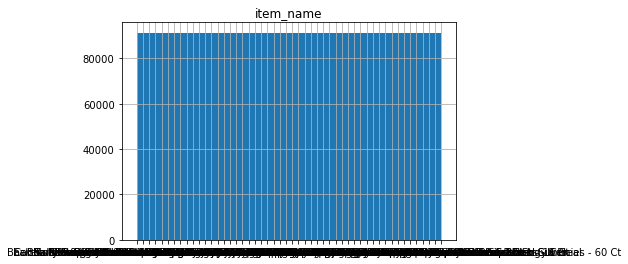

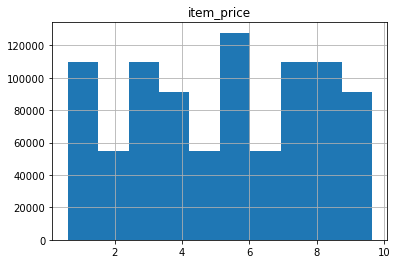

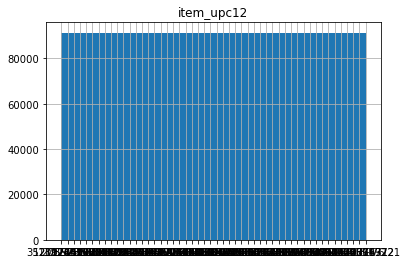

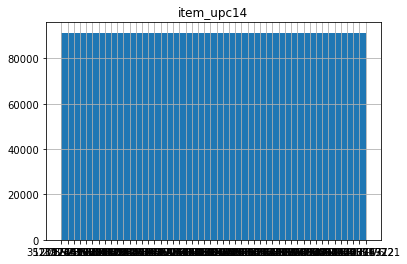

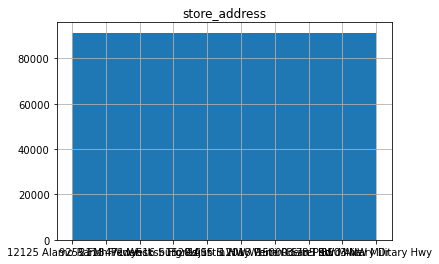

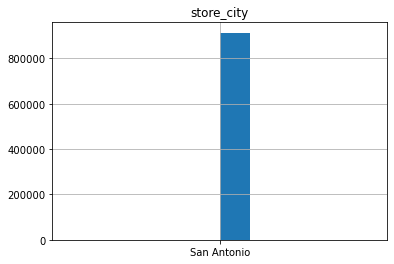

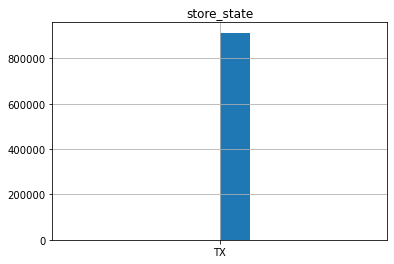

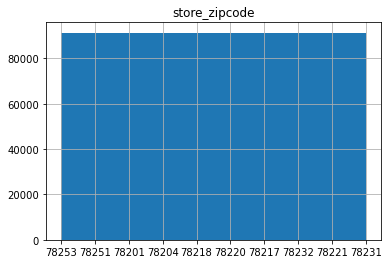

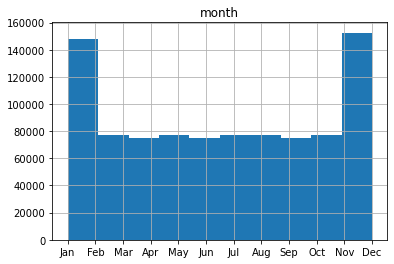

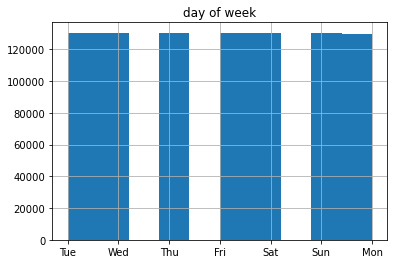

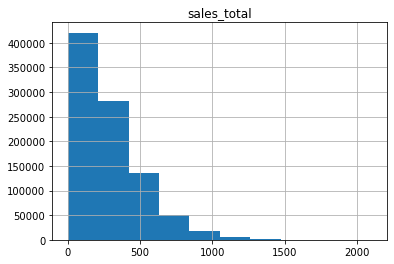

In [105]:
#prepare it 
sales = prepare.prepare(sales)

## Split data (train/validate/test)

In [106]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sale_amount    913000 non-null  float64
 1   item_brand     913000 non-null  object 
 2   item_name      913000 non-null  object 
 3   item_price     913000 non-null  float64
 4   item_upc12     913000 non-null  object 
 5   item_upc14     913000 non-null  object 
 6   store_address  913000 non-null  object 
 7   store_city     913000 non-null  object 
 8   store_state    913000 non-null  object 
 9   store_zipcode  913000 non-null  object 
 10  month          913000 non-null  object 
 11  day of week    913000 non-null  object 
 12  sales_total    913000 non-null  float64
dtypes: float64(3), object(10)
memory usage: 129.8+ MB


In [107]:
def split_resample_data(df, method='human'):
    """ 
    """

    df = df.resample('W').sum()
    df = df[df.index != '2016-02-29']
    df = df.rename(columns={'sale_amount':'quantity', 'sales_total': 'revenue'})
    df = df.drop(columns='item_price')

    if method == 'human':
        test = df.loc['2017']
        validate = df.loc['2016']
        train = df.loc[:'2015']
    else:
        train_size = int(len(df) * .5)
        validate_size = int(len(df) * .3)
        test_size = int(len(df) - train_size - validate_size)
        validate_end_index = train_size + validate_size

        train = df[: train_size]
        validate = df[train_size : validate_end_index]
        test = df[validate_end_index : ]

    train.revenue.plot()
    test.revenue.plot()

    return df, train, validate, test

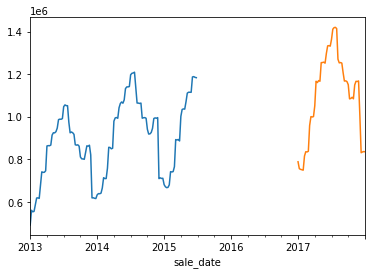

In [108]:
sales, train, validate, test = split_resample_data(sales, 'prop')

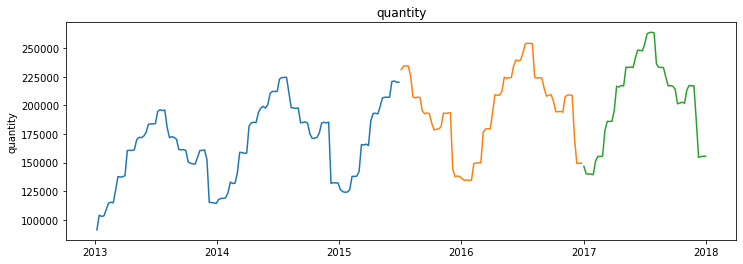

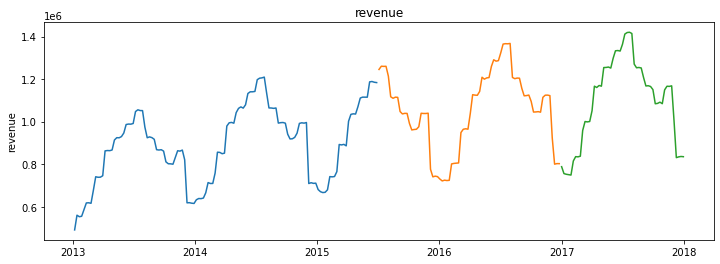

In [109]:
for col in train.columns:
    plt.figure(figsize=(12,4)),
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Resample by any period except daily. Aggregate using the sum.


In [110]:
sales = sales.resample('W').sum()

In [111]:
sales.loc['2015']

,quantity,revenue
sale_date,,
2015-01-04,126377.0,680561.67
2015-01-11,124535.0,670503.28
2015-01-18,124006.0,666371.29
2015-01-25,124240.0,667663.85
2015-02-01,126283.0,679407.51
2015-02-08,137972.0,741460.30
2015-02-15,137881.0,740259.72
2015-02-22,138075.0,741725.00
2015-03-01,142260.0,764901.96


## Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:


### Supporting Functions

In [112]:
#computing rmse 

def evaluate(target_var, df, yhat):
    rmse = round(sqrt(mean_squared_error(df[target_var], yhat[target_var])), 0)
    return rmse 

In [113]:
def plot_and_eval(target_var, train, validate, yhat):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth =1)
    plt.plot(yhat[target_var])
    plt.title(target_var)

    rmse = evaluate(target_var, validate, yhat)
    print(target_var, '--RMSE: {:.0f}'.format(rmse))

In [114]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [115]:
def append_eval_df(eval_df, model_type, target_var, df, yhat):
    
    rmse = evaluate(target_var, df, yhat)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)

    return eval_df.append(d, ignore_index=True)

### Last Observed Value
* Predict future values based on last observed value

In [116]:
sales

,quantity,revenue
sale_date,,
2013-01-06,91067.0,490767.50
2013-01-13,103902.0,559934.21
2013-01-20,102950.0,552813.52
2013-01-27,103298.0,554908.84
2013-02-03,109027.0,586547.55
...,...,...
2017-12-03,187286.0,1006145.15
2017-12-10,154400.0,830597.14
2017-12-17,155296.0,834271.29


In [117]:
items = train.quantity[-1:][0]
dollars = round(train.revenue[-1:][0],2)

yhat_df = pd.DataFrame({'quantity':[items], 'revenue':[dollars]},\
                        index=validate.index)

yhat_df

,quantity,revenue
sale_date,,
2015-07-05,220216.0,1183467.55
2015-07-12,220216.0,1183467.55
2015-07-19,220216.0,1183467.55
2015-07-26,220216.0,1183467.55
2015-08-02,220216.0,1183467.55
...,...,...
2016-11-27,220216.0,1183467.55
2016-12-04,220216.0,1183467.55
2016-12-11,220216.0,1183467.55


quantity --RMSE: 41420


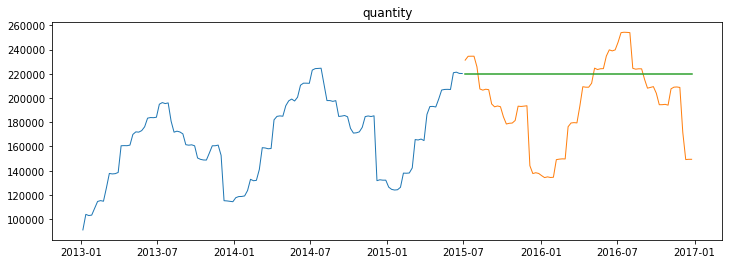

In [118]:
plot_and_eval('quantity', train, validate, yhat_df)

In [119]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, 'last_observed_value',\
                            target_var=col,\
                            df=validate,
                            yhat=yhat_df )

In [120]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,41420.0
1,last_observed_value,revenue,222409.0


### Simple Average
* Takes average of historical values and uses that value to predict future values
* Good option for initial baseline


In [121]:
items = round(train.quantity.mean(), 2)
dollars = round(train.revenue.mean(),2)

yhat_df = pd.DataFrame({'quantity':[items], 'revenue':[dollars]},\
                        index=validate.index)


In [122]:
yhat_df.head(3)

,quantity,revenue
sale_date,,
2015-07-05,165735.69,891060.57
2015-07-12,165735.69,891060.57
2015-07-19,165735.69,891060.57


quantity --RMSE: 45442
revenue --RMSE: 244233


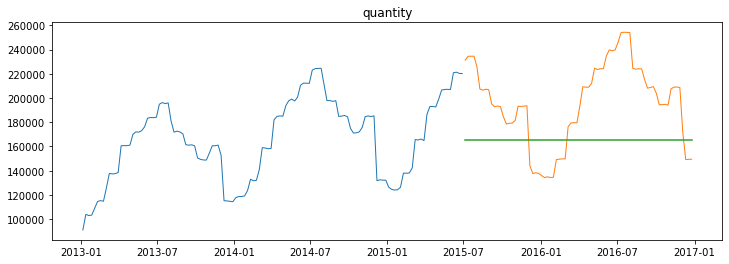

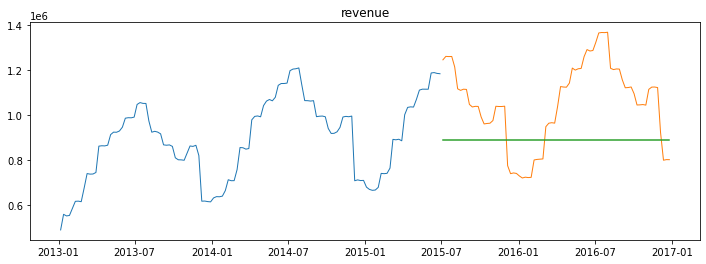

In [123]:
for col in train.columns:
    plot_and_eval(col, train, validate, yhat_df)

In [124]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, 'simple_average',\
                            target_var=col,\
                            df=validate,
                            yhat=yhat_df )

In [125]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,41420.0
1,last_observed_value,revenue,222409.0
2,simple_average,quantity,45442.0
3,simple_average,revenue,244233.0


### Moving Average
* Uses last n-day moving average to forecast. 


In [126]:
period = 30

items = round(train.quantity.rolling(period).mean().iloc[-1], 2)
dollars = round(train.revenue.rolling(period).mean().iloc[-1],2)

yhat_df = pd.DataFrame({'quantity':[items], 'revenue':[dollars]},\
                        index=validate.index)


In [127]:
yhat_df.head(3)

,quantity,revenue
sale_date,,
2015-07-05,168232.1,904485.49
2015-07-12,168232.1,904485.49
2015-07-19,168232.1,904485.49


quantity --RMSE: 43808
revenue --RMSE: 235451


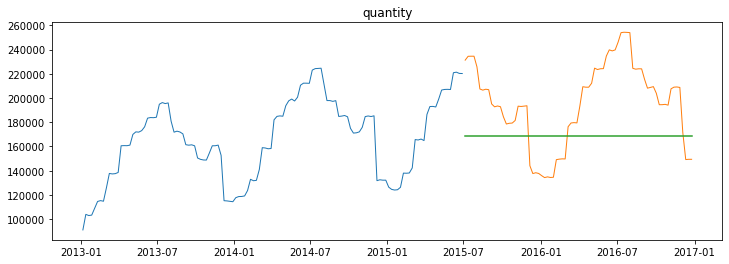

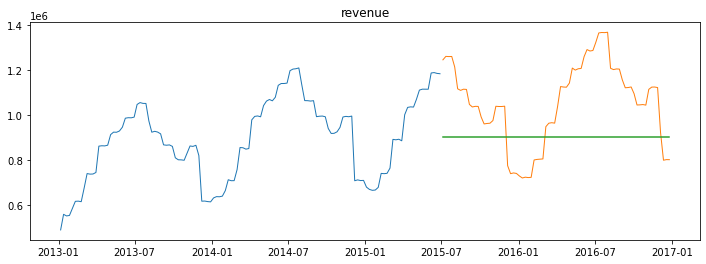

In [128]:
for col in train.columns:
    plot_and_eval(col, train, validate, yhat_df)

In [129]:
for col in train.columns:
    eval_df = append_eval_df(eval_df, '30d moving average',\
                            target_var=col,\
                            df=validate,
                            yhat=yhat_df )

In [130]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,41420.0
1,last_observed_value,revenue,222409.0
2,simple_average,quantity,45442.0
3,simple_average,revenue,244233.0
4,30d moving average,quantity,43808.0
5,30d moving average,revenue,235451.0


In [135]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train.quantity.rolling(p).mean().iloc[-1], 2)
    dollars = round(train.revenue.rolling(p).mean().iloc[-1],2)

    yhat_df = pd.DataFrame({'quantity':[items], 'revenue':[dollars]},\
                            index=validate.index)

    model_type = str(p) + 'W moving average'

    eval_df = append_eval_df(eval_df, model_type,\
                        target_var='quantity',\
                        df=validate,
                        yhat=yhat_df )

    eval_df = append_eval_df(eval_df, model_type,\
                        target_var='revenue',\
                        df=validate,
                        yhat=yhat_df)


In [139]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,41420.0
1,last_observed_value,revenue,222409.0
2,simple_average,quantity,45442.0
3,simple_average,revenue,244233.0
4,30d moving average,quantity,43808.0
5,30d moving average,revenue,235451.0
6,1d moving average,quantity,41420.0
7,1d moving average,revenue,222409.0
8,4d moving average,quantity,41697.0
9,4d moving average,revenue,223874.0


### Holt's Linear Trend Model
* alpha - smoothing level: smoothign parameter for mean, close to 1 will have less of smoothign affect, and greater weight on recent values
* beta - smoothing_slope : smothign parameter for slope, values closers to 1 give greater weight ot recent slope values

quantity 



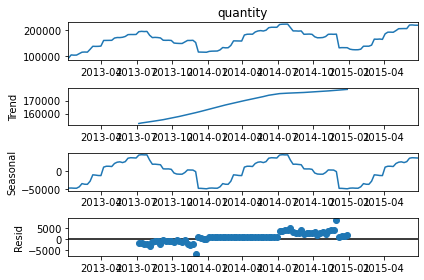

revenue 



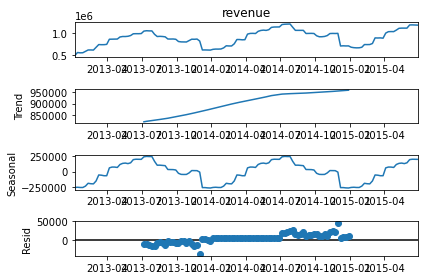

In [142]:
#looking at seasonal deomposition
for col in train.columns:
    print(col, '\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

### Making predictions with Model
* create, fit, predict with Holt Object
* exponential = True/False (exponsential vs linear growth, additive vs multiplicative)
* smoothing_level (alpha): value between (0,1)
smoothing_slope (beta): value between (0,1)

In [143]:
for col in train.columns:
    model = Holt(train[col], exponential= False)
    model = model.fit(smoothing_level=.1,
                        smoothing_slope=.1,
                        optimized=False)
    yhat_items = model.predict(start=validate.index[0],
                                end=validate.index[-1])
    yhat_df[col] = round(yhat_items,2)

quantity --RMSE: 176291
revenue --RMSE: 948224


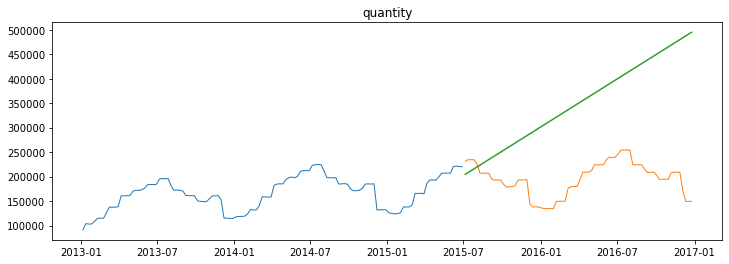

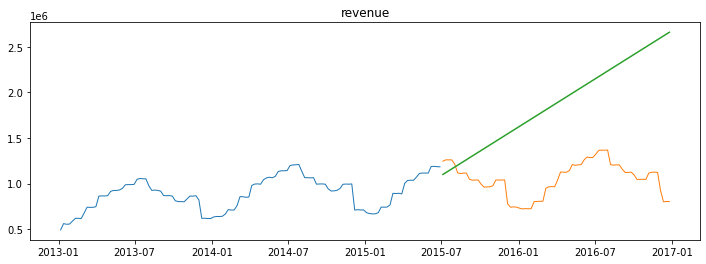

In [144]:
for col in train.columns:
    plot_and_eval(col, train, validate, yhat_df)

In [146]:
for col in train.columns:
    eval_df=append_eval_df(eval_df, model_type='Holts',
                            target_var=col, 
                            df=validate,
                            yhat=yhat_df)

In [147]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,41420.0
1,last_observed_value,revenue,222409.0
2,simple_average,quantity,45442.0
3,simple_average,revenue,244233.0
4,30d moving average,quantity,43808.0
5,30d moving average,revenue,235451.0
6,1d moving average,quantity,41420.0
7,1d moving average,revenue,222409.0
8,4d moving average,quantity,41697.0
9,4d moving average,revenue,223874.0


### Preidct Based on Previous Cycle
* Define a cyle, predict next cyle to be values of previous cycle
* Involves presplitting the data

In [148]:
train = sales.loc[:'2015']
validate =  sales.loc['2016']
test = sales.loc['2017']

In [154]:
yhat_df = round(train['2015'] + train.diff(52).mean(), 2)

In [155]:
pd.concat([yhat_df.head(1), validate.head(1)])

,quantity,revenue
sale_date,,
2015-01-04,141777.38,763367.06
2016-01-03,135889.00,729993.32


In [156]:
yhat_df.index = validate.index

In [157]:
len(yhat_df)

52

quantity --RMSE: 4187
revenue --RMSE: 22730


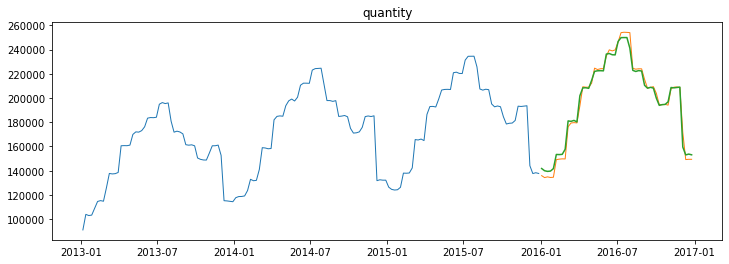

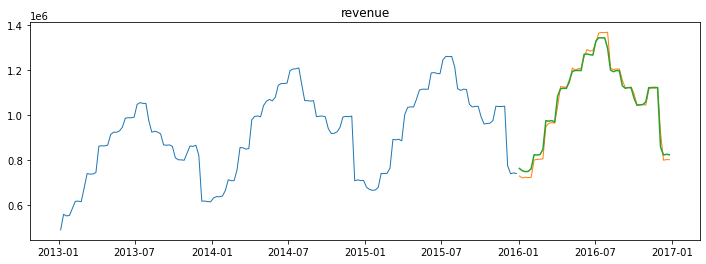

In [158]:
for col in train.columns:
    plot_and_eval(col, train, validate, yhat_df)
    eval_df = append_eval_df(eval_df, model_type='previous_year', 
                            target_var=col,
                            df=validate, 
                            yhat=yhat_df)

In [159]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,41420.0
1,last_observed_value,revenue,222409.0
2,simple_average,quantity,45442.0
3,simple_average,revenue,244233.0
4,30d moving average,quantity,43808.0
5,30d moving average,revenue,235451.0
6,1d moving average,quantity,41420.0
7,1d moving average,revenue,222409.0
8,4d moving average,quantity,41697.0
9,4d moving average,revenue,223874.0


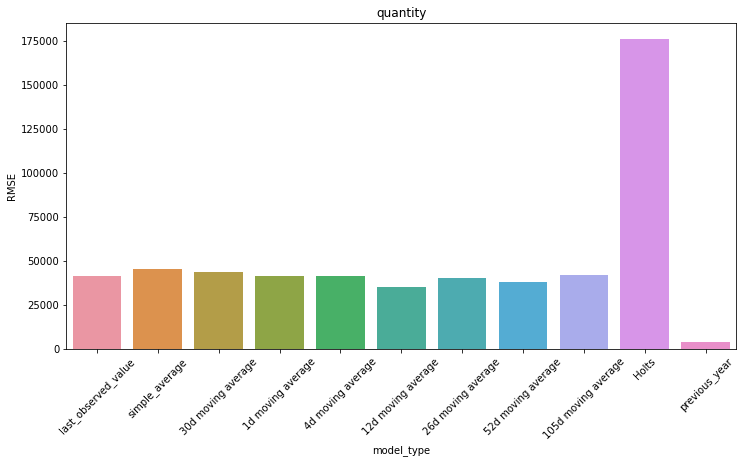

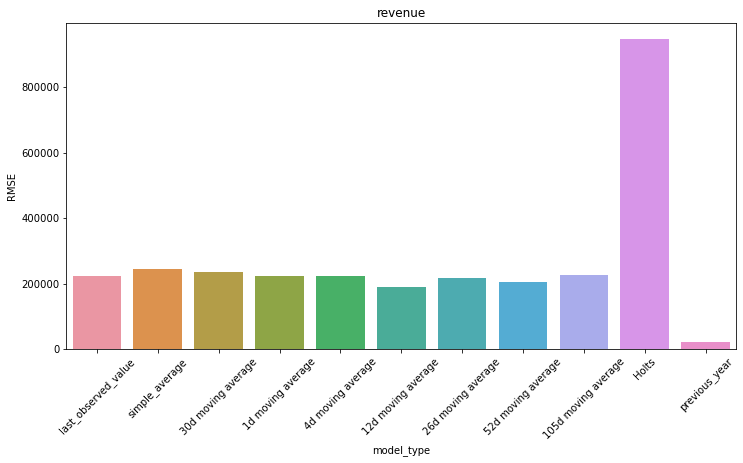

In [160]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

In [164]:
test = test[test.index != '2016-02-29']

In [195]:
yhat_df = validate + train.diff(52).mean()
week_53 = pd.DataFrame(yhat_df.iloc[51]).T
yhat_df = pd.concat([yhat_df, week_53])
yhat_df.index = test.index

In [196]:
rmse_dollars = round(sqrt(mean_squared_error(test['revenue'], yhat_df['revenue'])), 0)
rmse_items = round(sqrt(mean_squared_error(test['quantity'], yhat_df['quantity'])), 0)

In [200]:
def plot_and_eval_test(target_var, train, validate, test, yhat):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth =1)
    plt.plot(test[target_var], label='Test', linewidth=1)
    plt.plot(yhat[target_var])
    plt.title(target_var)
    plt.legend()
    plt.show(0)


rmse - revenue:  43919.0
rmse - quantity: 8166.0


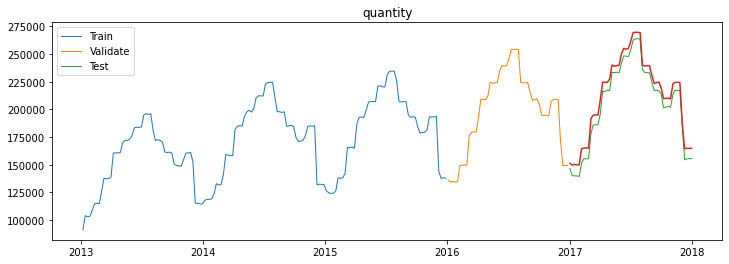

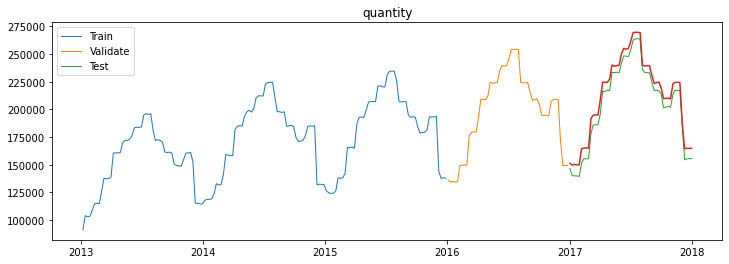

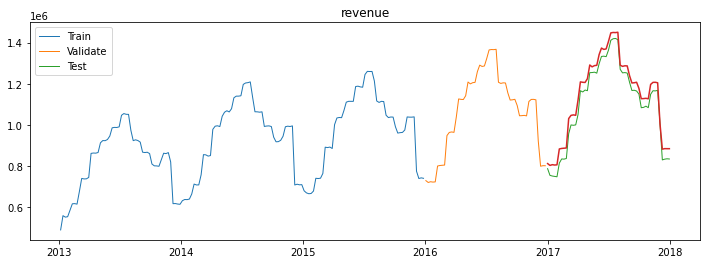

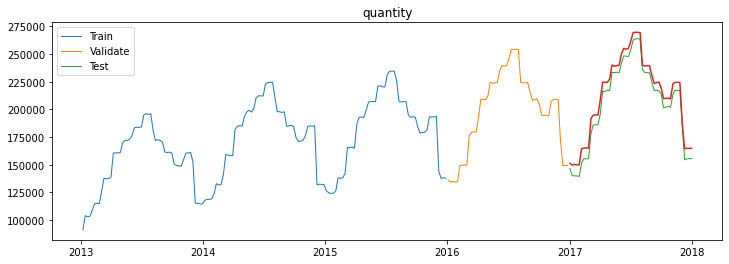

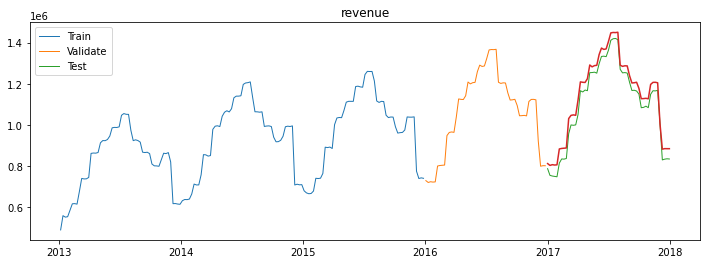

In [201]:
print('rmse - revenue: ', rmse_dollars)
print('rmse - quantity:', rmse_items)

for col in train.columns:
    plot_and_eval_test(col, train, validate, test, yhat_df)

### Based on previous year/month/etc., this is up to you.
